In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bigfile import BigFile
import glob
import os
import struct
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns
import pickle
import warnings

# Seaborn and Matplotlib configurations
sns.set()
sns.set_palette("Set2")
sns.set_style('ticks', {'ytick.direction': 'in', 'xtick.direction': 'in'})
sns.set_context("paper", font_scale=1.7, rc={"axes.linewidth": 1.3, "lines.linewidth": 2.5, "patch.linewidth": 2.2})

# Additional configurations
cmap = plt.get_cmap("Set2")

In [2]:
datadir = "/hildafs/home/hoffmanc/scratch/dualAGN/pair_catalog/"
pairs1 = np.load(datadir + 'pair-m1e7-dr=200kpc-pig483.npy')
print("Number of loaded pairs:",len(pairs1))

Number of loaded pairs: 20454


In [3]:
def pairwise_rmax(poslist, scalefac):
    rmax = 0.
    nn = len(poslist)
    for i in range(nn):
        for j in range(i+1, nn):
            dr = get_dr(poslist[i], poslist[j], scalefac=scalefac)
            rmax = max(rmax, dr)
    return rmax

In [4]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

def get_dr(pos1, pos2, box=250000., scalefac = 1):
    dpos = pos1 - pos2
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos, axis=-1)*scalefac

In [5]:
def get_bh_pos(snap, allbhs):
    pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d'%snap)
    nmax = 10000000
    ids = pig['5/ID'][:nmax]
    sort_idx = ids.argsort()
    idxlist = sort_idx[np.searchsorted(ids,allbhs,sorter = sort_idx)]
    bhpos = pig['5/Position'][:nmax][idxlist]
    return bhpos

def get_tuples(snap, z, pairs, rthr):
    ids = np.unique(np.concatenate([pairs['id1'], pairs['id2']]).flatten())
    pos_arr = get_bh_pos(snap, ids)
    idset = set(ids)
    print("Total number of ids:",len(ids))
    
    # 6 bhs:
    set6 = set()
    for i, bid in enumerate(list(idset)):
        dr_arr = get_dr(pos_arr, pos_arr[i], scalefac=1./(1+z))
        mask = dr_arr < rthr
        tuples = tuple(sorted(ids[mask]))
        if len(tuples) == 6 and tuples not in set6:
            rmax =  pairwise_rmax(poslist=pos_arr[mask], scalefac=1./(1+z))
            if rmax < rthr:
                set6.add(tuples)
                for ii in tuples:
                    try:
                        idset.remove(ii)
                    except:
                        # print(ii)
                        continue

    # 5 bhs:
    set5 = set()
    ids = np.array(list(idset))
    # print("Remaining ids:",len(ids))
    pos_arr = get_bh_pos(snap, ids)
    for i, bid in enumerate(list(idset)):
        dr_arr = get_dr(pos_arr, pos_arr[i], scalefac=1./(1+z))
        mask = dr_arr < rthr
        tuples = tuple(sorted(ids[mask]))
        if len(tuples) == 5 and tuples not in set5:
            rmax =  pairwise_rmax(poslist=pos_arr[mask], scalefac=1./(1+z))
            if rmax < rthr:
                set5.add(tuples)
                for ii in tuples:
                    try:
                        idset.remove(ii)
                    except:
                        # print(ii)
                        continue
    
    # 4 bhs:
    set4 = set()
    ids = np.array(list(idset))
    # print("Remaining ids:",len(ids))
    pos_arr = get_bh_pos(snap, ids)
    for i, bid in enumerate(list(idset)):
        dr_arr = get_dr(pos_arr, pos_arr[i], scalefac=1./(1+z))
        mask = dr_arr < rthr
        tuples = tuple(sorted(ids[mask]))
        if len(tuples) == 4 and tuples not in set4:
            rmax =  pairwise_rmax(poslist=pos_arr[mask], scalefac=1./(1+z))
            if rmax < rthr:
                set4.add(tuples)
                for ii in tuples:
                    try:
                        idset.remove(ii)
                    except:
                        # print(ii)
                        continue
    
    # 3 bhs:
    set3 = set()
    ids = np.array(list(idset))
    pos_arr = get_bh_pos(snap, ids)
    # print("Remaining ids:",len(ids))
    for i, bid in enumerate(list(idset)):
        dr_arr = get_dr(pos_arr, pos_arr[i], scalefac=1./(1+z))
        mask = dr_arr < rthr
        tuples = tuple(sorted(ids[mask]))
        if len(tuples) == 3 and tuples not in set3:
            rmax =  pairwise_rmax(poslist=pos_arr[mask], scalefac=1./(1+z))
            if rmax < rthr:
                set3.add(tuples)
                for ii in tuples:
                    try:
                        idset.remove(ii)
                    except:
                        # print(ii)
                        continue
    return set6, set5, set4, set3

In [6]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_483')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)

----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [7]:
set6, set5, set4, set3 = get_tuples(snap=483, z=redshift, pairs=pairs1, rthr=30)
set6_z1, set5_z1, set4_z1, set3_z1 = list(set6), list(set5), list(set4), list(set3)
print("Number of BH tuples with 6 BHs:",len(set6_z1))
print("Number of BH tuples with 5 BHs:",len(set5_z1))
print("Number of BH tuples with 4 BHs:",len(set4_z1))
print("Number of BH tuples with 3 BHs:",len(set3_z1))

Total number of ids: 23279
Remaining ids: 23273
189120027235
190300387606
190754027667
193930409769
Remaining ids: 23252
302173721354
302748113800
304290847290
215841074126
215991889640
216475906109
Remaining ids: 23002
187805194784
188682648222
262301053868
262663734833
320626322807
320838078347
191108347810
194193418800
312115408652
313748578683
307353489804
308351640775
277241101420
278239477895
222637207339
223393825870
182333837737
183906865204
281162000078
282765365522
298995968794
299449806785
168178812703
168692826223
225778858537
226716454478
223314228513
224221436987
331845888247
332057308343
173117088589
173873393644
206986731385
208075401362
Number of BH tuples with 6 BHs: 1
Number of BH tuples with 5 BHs: 5
Number of BH tuples with 4 BHs: 64
Number of BH tuples with 3 BHs: 553


In [8]:
nmax = 1000000000
bhmass = pig['5/BlackholeMass'][:nmax]*1e10/hh
mask = bhmass > 1e7
print("Total BH mass of valid BHs:",sum(mask))

Total BH mass of valid BHs: 83589


In [9]:
trip = set3_z1
quad = set4_z1

bh3 = np.array(trip).flatten()
bh4 = np.array(quad).flatten()

allbhs = np.unique(np.concatenate([bh3, bh4])).astype('uint64')

# get bhpos
snap = 348
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')
nmax = 100000000
ids = pig['5/ID'][:nmax]
sort_idx = ids.argsort()
idxlist = sort_idx[np.searchsorted(ids,allbhs,sorter = sort_idx)]

bhpos = pig['5/Position'][:nmax][idxlist]
bhlx = calc_lx(pig['5/BlackholeAccretionRate'][:nmax][idxlist].astype(np.float64)*mdot_msun_yr)
bhmass = pig['5/BlackholeMass'][:nmax][idxlist]*1e10/hh
bhid = pig['5/ID'][:][idxlist]
bhdict = {bid: (bhpos[i], bhlx[i], bhmass[i]) for i, bid in enumerate(allbhs)}

In [10]:
drlist_z1 = np.zeros((len(trip), 3))
lxlist_z1 = np.zeros((len(trip), 3))
mmlist_z1 = np.zeros((len(trip), 3))


for i,tt in enumerate(trip[:]):
    id1, id2, id3 = tt[0], tt[1], tt[2]

    d12 = get_dr(bhdict[id1][0], bhdict[id2][0], box=250000., scalefac=0.3333)
    d13 = get_dr(bhdict[id1][0], bhdict[id3][0], box=250000., scalefac=0.33333)
    d23 = get_dr(bhdict[id2][0], bhdict[id3][0], box=250000., scalefac=0.33333)

    
    drlist_z1[i][0], drlist_z1[i][1], drlist_z1[i][2] = d12, d13, d23
    
    lx1 = bhdict[id1][1]
    lx2 = bhdict[id2][1]
    lx3 = bhdict[id3][1]
    
    
    lxs = np.sort(np.array([lx1, lx2, lx3]))
    lxlist_z1[i][0], lxlist_z1[i][1], lxlist_z1[i][2] = lxs[2], lxs[1], lxs[0]

In [11]:
drlist = drlist_z1
lxlist = lxlist_z1
rmax = np.max(drlist, axis=1)
rmin = np.min(drlist, axis=1)

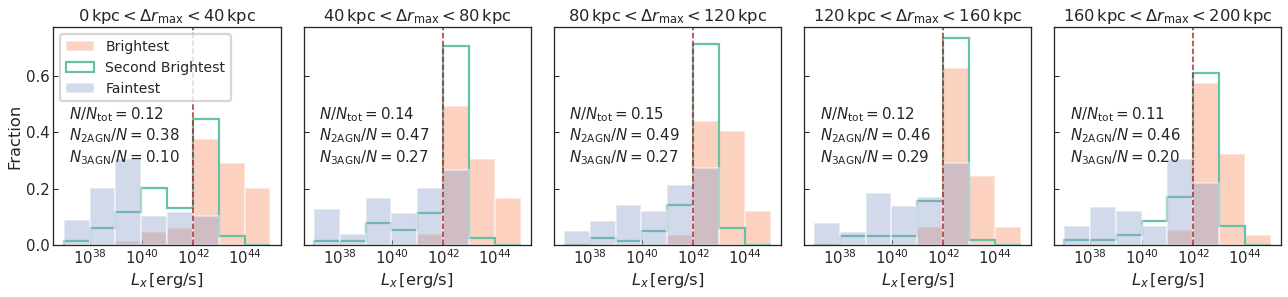

In [12]:
bins = [0,40,80,120,160,200]
lbins = np.logspace(36.99,44.99,9)
lxlist2 = np.sort(lxlist, axis=1)

fig, ax = plt.subplots(1,5,figsize=(22,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)
ax = ax.flatten()
Ntot = len(lxlist2)
for i in range(5):
    r1, r2 = bins[i], bins[i+1]
    mask = rmax > r1
    mask &= rmax <= r2
    lx = lxlist2[mask]
    N = sum(mask)
    N3 = sum(lx[:,0] >= 1e42)
    N2 = sum((lx[:,1] >= 1e42) & (lx[:,0]< 1e42))
    ax[i].hist(lx[:,2], bins=lbins, alpha=0.4,color=cmap(1), weights = np.ones(N)/N, label='Brightest')
    ax[i].hist(lx[:,1], bins=lbins, histtype='step',color=cmap(0), weights = np.ones(N)/N, label='Second Brightest')
    ax[i].hist(lx[:,0], bins=lbins, alpha=0.4,color=cmap(2), weights = np.ones(N)/N, label='Faintest')
    ax[i].axvline(1e42, linestyle='--', color='brown', linewidth=1.5)
    ax[i].set(xscale='log', xlabel=r'$L_x\,[{\rm erg/s}]$', title=r'$%d\,{\rm kpc} < \Delta r_{\rm max} < %d\,{\rm kpc}$'%(r1,r2))
    ax[i].text(0.07,0.38,r'$N/N_{\rm tot} = %.2f$'%(N/Ntot) + '\n'  + r'$N_{\rm 2AGN}/N = %.2f$'%(N2/N) + '\n'  + r'$N_{\rm 3AGN}/N = %.2f$'%(N3/N), transform=ax[i].transAxes, fontsize=15)
    
ax[0].legend(loc='upper left', fontsize=14)
ax[0].set(ylabel='Fraction')
# plt.savefig('lx_rbin.png', dpi=150, bbox_inches='tight', facecolor='w', transparent=False)
plt.show()